In [1]:
cd ..

/scratch/xc1490/projects/FoV


In [2]:
import argparse
from ast import arg, parse
import random
from datetime import datetime
import numpy as np
import glob
import math
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
import os
import copy
import time
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sys
import wandb
wandb.__version__
from utils import *
# from dataloader import
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
parser = argparse.ArgumentParser(description='FoV')
# basic config
parser.add_argument('--model', type=str, required=False, default='XGBOOST',
                    help='model name, options: [Autoformer, Transformer, iTransformer, Reformer, TimesNet, PatchTST]')
parser.add_argument('--root_path', type=str, default=f'{os.getcwd()}', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='/processed_data', help='data file')
parser.add_argument('--hist_time', type=int, default=2, help='history data time')
parser.add_argument('--pred_time', type=int, default=2, help='prediction data time')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--feature_names', type=str, default='XYZ_FEATURE_NAMES', help='[DEFAULT_FEATURE_NAMES, XYZ_FEATURE_NAMES, ONE_FEATURE, SC_FEATURE_NAMES, RPY_FEATURE_NAMES, ANGLE_FEATURE_NAMES]')
parser.add_argument('--load_model', type=bool, default=False, help='load model')
parser.add_argument('--use_wandb', type=bool, default=False, help='use wandb for logging')
# transformer config
parser.add_argument('--n_heads', type=int, default=3, help='number of heads')
parser.add_argument('--head_dim', type=int, default=3, help='head dimension')
parser.add_argument('--dim_val', type=int, default=9, help='embedding dimension')
parser.add_argument('--n_decoder_layers', type=int, default=2, help='number of decoder layers')
parser.add_argument('--n_encoder_layers', type=int, default=2, help='number of encoder layers')
parser.add_argument('--pe_mode', type=str, default='standard', help='positional encoding mode')


_StoreAction(option_strings=['--pe_mode'], dest='pe_mode', nargs=None, const=None, default='standard', type=<class 'str'>, choices=None, help='positional encoding mode', metavar=None)

In [4]:
args = parser.parse_args(args=[])
args

Namespace(batch_size=16, data_path='/processed_data', dim_val=9, feature_names='XYZ_FEATURE_NAMES', head_dim=3, hist_time=2, load_model=False, model='XGBOOST', n_decoder_layers=2, n_encoder_layers=2, n_heads=3, pe_mode='standard', pred_time=2, root_path='/scratch/xc1490/projects/FoV', use_wandb=False)

In [5]:
fix_seed = 2024
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
id = datetime.now().strftime("%m/%d/%Y-%H:%M:%S")
saved_path = f'saved_results/{id}'
if not os.path.exists(saved_path):
    os.makedirs(saved_path)
# parse augments


# config
PROJECT_PATH = args.root_path
FRAME_RATE = 60 # 60 frames/sec
MAX_HISTORY_TIME = 10
MAX_PREDICTION_TIME = 10
HISTORY_TIME = args.hist_time
PREDICTION_TIME = args.pred_time
HISTORY_LENGTH = HISTORY_TIME*FRAME_RATE
PREDICTION_LENGTH = PREDICTION_TIME*FRAME_RATE
MAX_HISTORY_LENGTH = MAX_HISTORY_TIME*FRAME_RATE
MAX_PREDICTION_LENGTH = MAX_PREDICTION_TIME*FRAME_RATE
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", DEVICE)
TOTAL_FEATURE_NAMES = ['head_x','head_y','head_z','head_r_sin','head_r_cos','head_p_sin','head_p_cos','head_y_sin',\
'head_y_cos','head_rx','head_ry','head_rz']
DEFAULT_FEATURE_NAMES = ['head_x','head_y','head_z','head_r_sin','head_r_cos','head_p_sin','head_p_cos','head_y_sin',\
'head_y_cos']
XYZ_FEATURE_NAMES = ['head_x', 'head_y', 'head_z']
ONE_FEATURE = ['head_x']
SC_FEATURE_NAMES = ['head_r_sin','head_r_cos','head_p_sin','head_p_cos','head_y_sin','head_y_cos']
RPY_FEATURE_NAMES = ['head_rx','head_ry','head_rz']
ANGLE_FEATURE_NAMES = ['head_r_cos','head_p_sin','head_p_cos','head_y_sin','head_y_cos','head_rx','head_ry','head_rz']
FEATURE_NAMES = eval(args.feature_names)
FEATURE_INDEX = [TOTAL_FEATURE_NAMES.index(x) for x in FEATURE_NAMES]
DEFAULT_FEATURE_SIZE = len(DEFAULT_FEATURE_NAMES)
FEATURE_SIZE = len(FEATURE_NAMES)
BATCH_SIZE = args.batch_size
LOAD_MODEL = args.load_model

# load data
processed_data_path = f'{PROJECT_PATH}/processed_data'
x_train = np.loadtxt(f'{processed_data_path}/x_train_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,DEFAULT_FEATURE_SIZE))
y_train = np.loadtxt(f'{processed_data_path}/y_train_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,PREDICTION_LENGTH,DEFAULT_FEATURE_SIZE))
x_val = np.loadtxt(f'{processed_data_path}/x_val_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,DEFAULT_FEATURE_SIZE))
y_val = np.loadtxt(f'{processed_data_path}/y_val_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,PREDICTION_LENGTH,DEFAULT_FEATURE_SIZE))
x_test = np.loadtxt(f'{processed_data_path}/x_test_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,DEFAULT_FEATURE_SIZE))
y_test = np.loadtxt(f'{processed_data_path}/y_test_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,PREDICTION_LENGTH,DEFAULT_FEATURE_SIZE))
mean_std = np.loadtxt(f'{processed_data_path}/xyz_mean_std_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((3, -1))

# create dataset and dataloader
feature_names = FEATURE_NAMES
feature_idx = FEATURE_INDEX
x_train = x_train[:,:,feature_idx]
y_train = y_train[:,:,feature_idx]
x_val = x_val[:,:,feature_idx]
y_val = y_val[:,:,feature_idx]
x_test = x_test[:,:,feature_idx]
y_test = y_test[:,:,feature_idx]
train_data = FoVDataset(x_train, y_train, feature_idx)
val_data = FoVDataset(x_val, y_val, feature_idx)
test_data = FoVDataset(x_test, y_test, feature_idx)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


#training hyperparams
in_seq_len = HISTORY_LENGTH
out_seq_len = PREDICTION_LENGTH
feature_size = FEATURE_SIZE
lr = 0.005
tf_rate = 0.5
epochs = 200
batch_size = BATCH_SIZE
n_batches = len(train_dataloader)
use_wandb = args.use_wandb
# init model
model_name = args.model

device:  cpu


# vanilla XGBoost

In [7]:
if model_name == 'XGBOOST':
    import xgboost as xgb #pip install xgboost
    # https://www.kaggle.com/code/furiousx7/xgboost-time-series
    reg = xgb.XGBRegressor(n_estimators=1000)
    #import pdb;pdb.set_trace()
    bs, input_temporal_dim, input_feature_dim = x_train.shape
    bs, output_temporal_dim, output_feature_dim = y_train.shape
#     x_train = np.swapaxes(x_train,2,1).reshape(x_train.shape[0], -1)
#     x_test = x_test.reshape(x_test.shape[0], -1)
#     y_train = y_train.reshape(y_train.shape[0], -1)
#     y_test = y_test.reshape(y_test.shape[0], -1)
    x_train = np.swapaxes(x_train,2,1).reshape(-1, input_temporal_dim)
    x_test = np.swapaxes(x_test,2,1).reshape(-1, input_temporal_dim)
    y_train = np.swapaxes(y_train,2,1).reshape(-1, output_temporal_dim)
    y_test = np.swapaxes(y_test,2,1).reshape(-1, output_temporal_dim)
    print ('x_train shape: {}, y_train shape: {}, x_test shape: {}, y_test shape: {}'.format(\
                x_train.shape, y_train.shape, x_test.shape, y_test.shape))
    reg.fit( x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train
    y_pred = reg.predict(x_test)

x_train shape: (17868, 120), y_train shape: (17868, 120), x_test shape: (456, 120), y_test shape: (456, 120)


/home/xc1490/.local/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


In [8]:
#np.save('/scratch/xc1490/projects/FoV/saved_results/tmp_xgboost_pred.npy',y_pred)

In [17]:
y_pred_train = reg.predict(x_train)

In [10]:
y_test = np.swapaxes(y_test.reshape(-1, output_feature_dim, output_temporal_dim),2,1)
y_pred = np.swapaxes(y_pred.reshape(-1, output_feature_dim, output_temporal_dim ),2,1)

In [13]:
x_test = np.swapaxes(x_test.reshape(-1, input_feature_dim, input_temporal_dim),2,1)

In [18]:
x_train = np.swapaxes(x_train.reshape(-1, input_feature_dim, input_temporal_dim),2,1)
y_train = np.swapaxes(y_train.reshape(-1, output_feature_dim, output_temporal_dim),2,1)

In [19]:
y_pred_train = np.swapaxes(y_pred_train.reshape(-1, output_feature_dim, output_temporal_dim),2,1)

In [29]:
np.random.randint(y_test.shape[0],size=(sample_nums))

array([107,  65,   8, 129,  45,  64, 140,   7, 139, 122])

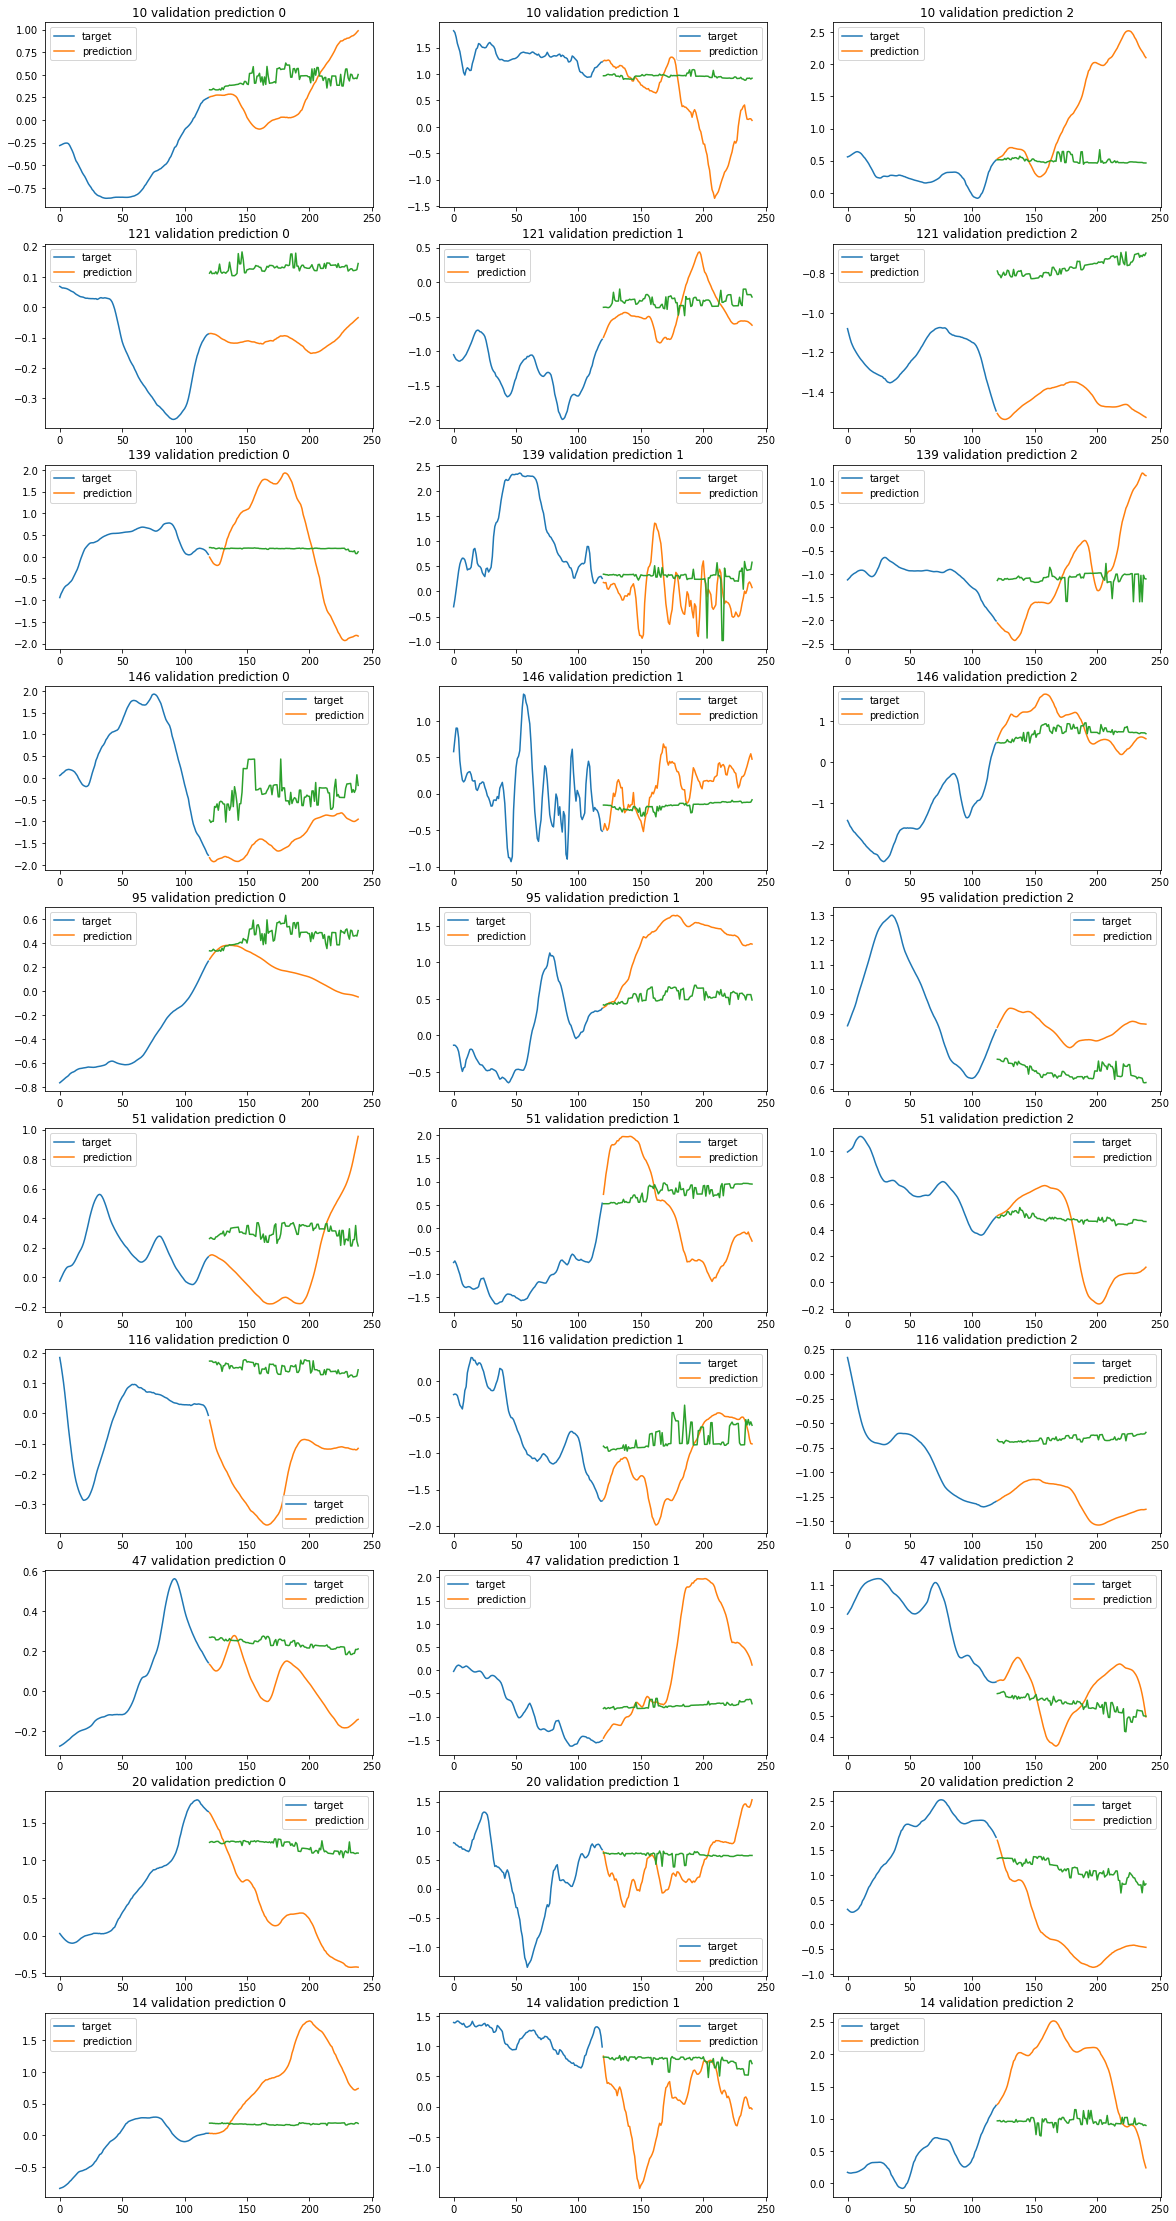

In [34]:
sample_nums = 10
fig, ax = plt.subplots(sample_nums,3,figsize=(20,4*sample_nums))
for j, sample_id in enumerate(np.random.randint(y_test.shape[0],size=(sample_nums))):
        for i in range(3):  
            ax[j,i].plot(np.arange(0,input_temporal_dim), x_test[sample_id,:,i ],label='input')
            ax[j,i].plot(np.arange(input_temporal_dim, input_temporal_dim+output_temporal_dim),y_test[sample_id,:,i ],label='target')
            ax[j,i].plot(np.arange(input_temporal_dim, input_temporal_dim+output_temporal_dim),y_pred[sample_id,:,i ],label='prediction')
            ax[j,i].legend(['target','prediction'])
            ax[j,i].set_title('{} validation prediction {}'.format(sample_id, i))

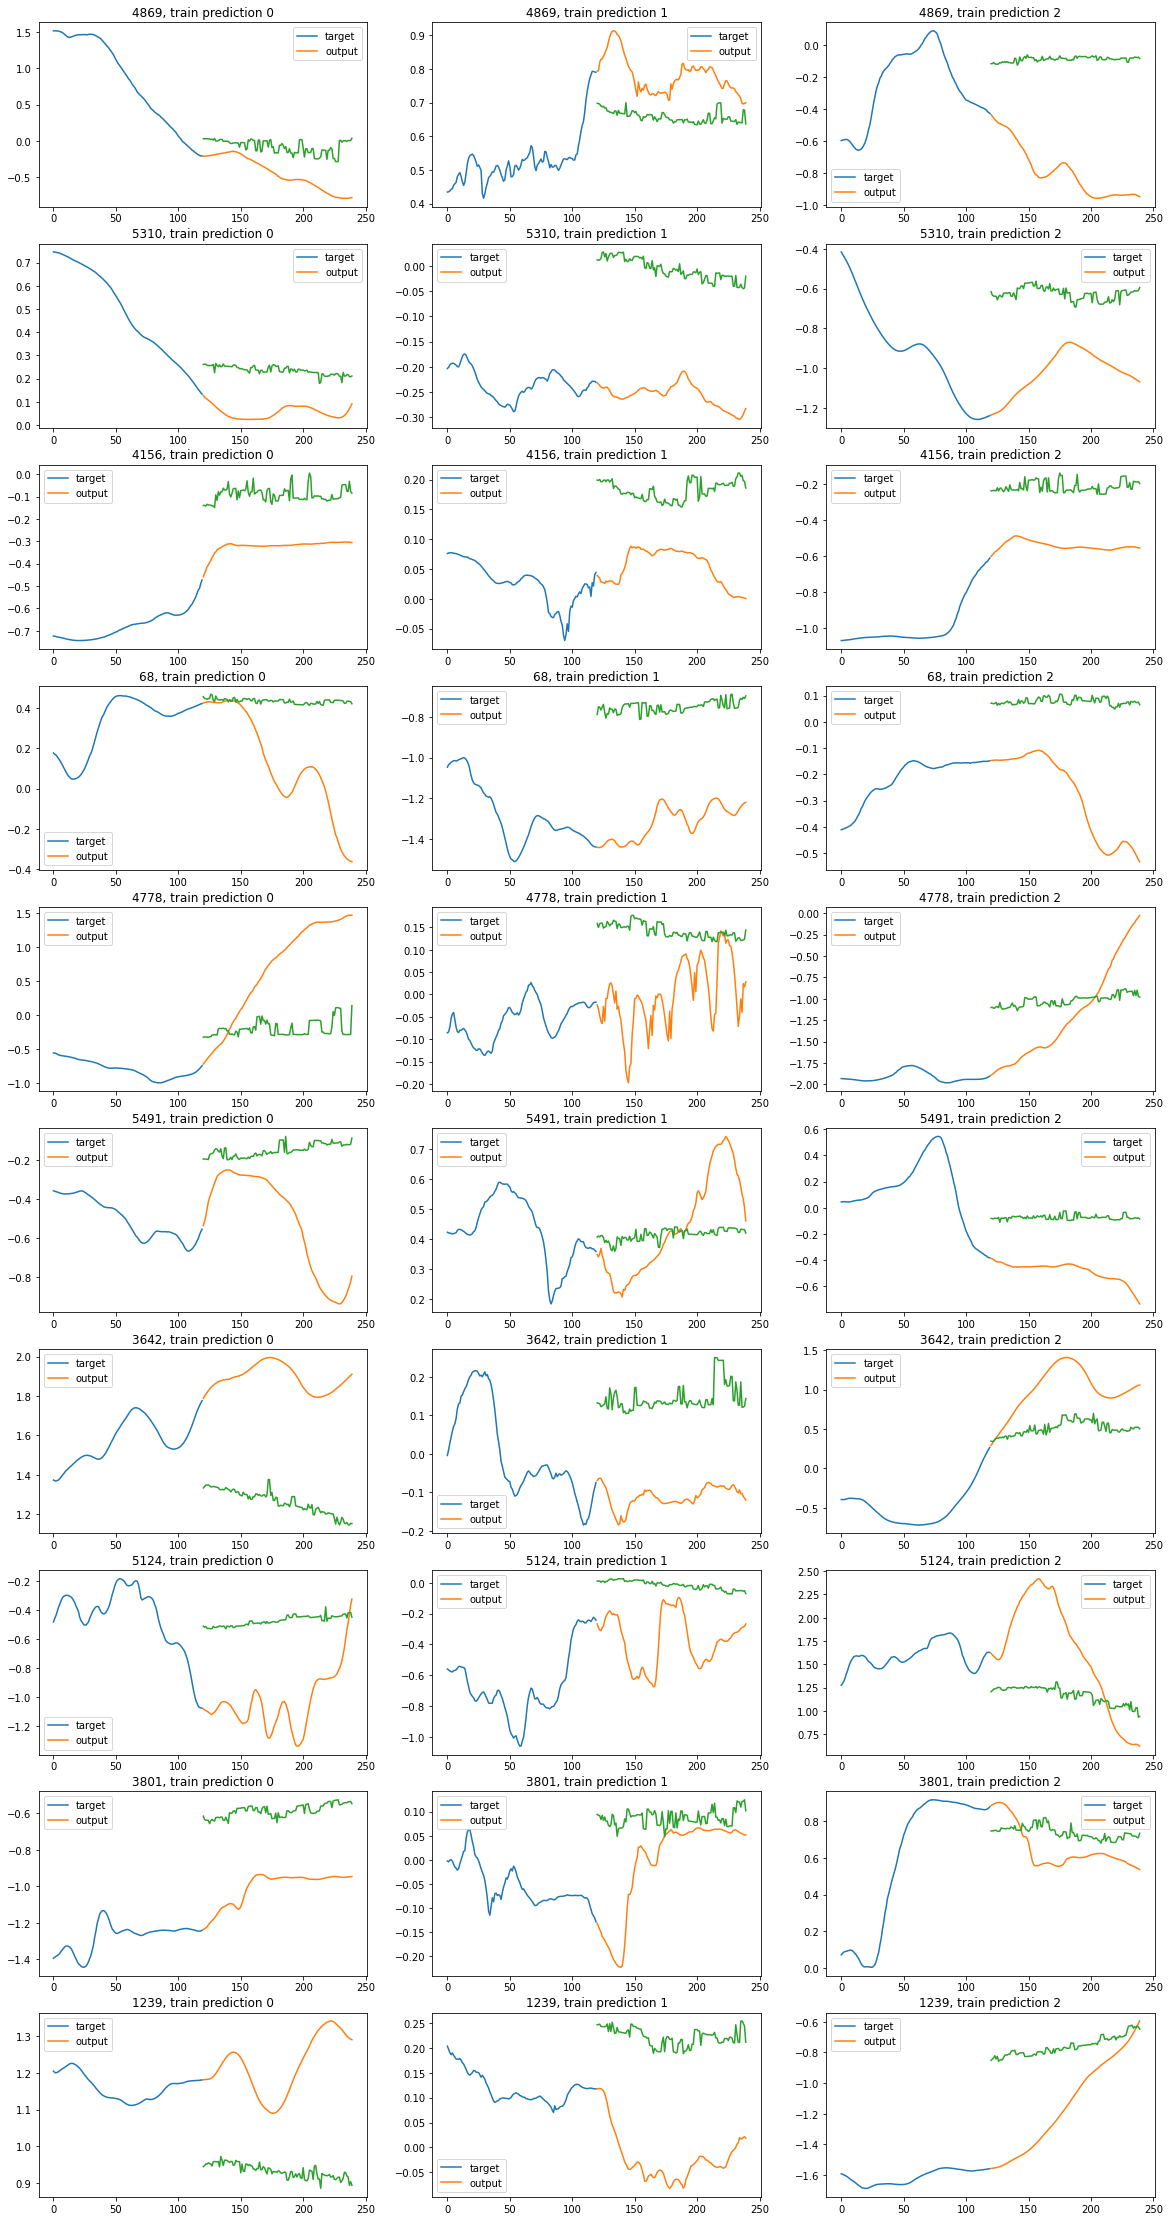

In [35]:
sample_nums = 10
fig, ax = plt.subplots(sample_nums,3,figsize=(20,4*sample_nums))
for j, sample_id in enumerate(np.random.randint(y_train.shape[0],size=(sample_nums))):
        for i in range(3):  
            ax[j, i ].plot(np.arange(0,input_temporal_dim), x_train[sample_id,:,i ],label='input')
            ax[j, i ].plot(np.arange(input_temporal_dim, input_temporal_dim+output_temporal_dim),y_train[sample_id,:,i ],label='target')
            ax[j, i ].plot(np.arange(input_temporal_dim, input_temporal_dim+output_temporal_dim),y_pred_train[sample_id,:,i ],label='prediction')
            ax[j, i ].legend(['target','output'])
            ax[j, i ].set_title('{}, train prediction {}'.format(sample_id, i))

# we should consider adding timestamps
- [ ] add only to input
- [ ] add to both input and output consecutive numbers for model to reason on it
but for xgboost we reshape so no use at all?

In [6]:
fix_seed = 2024
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
id = datetime.now().strftime("%m/%d/%Y-%H:%M:%S")
saved_path = f'saved_results/{id}'
if not os.path.exists(saved_path):
    os.makedirs(saved_path)
# parse augments


# config
PROJECT_PATH = args.root_path
FRAME_RATE = 60 # 60 frames/sec
MAX_HISTORY_TIME = 10
MAX_PREDICTION_TIME = 10
HISTORY_TIME = args.hist_time
PREDICTION_TIME = args.pred_time
HISTORY_LENGTH = HISTORY_TIME*FRAME_RATE
PREDICTION_LENGTH = PREDICTION_TIME*FRAME_RATE
MAX_HISTORY_LENGTH = MAX_HISTORY_TIME*FRAME_RATE
MAX_PREDICTION_LENGTH = MAX_PREDICTION_TIME*FRAME_RATE
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", DEVICE)
TOTAL_FEATURE_NAMES = ['head_x','head_y','head_z','head_r_sin','head_r_cos','head_p_sin','head_p_cos','head_y_sin',\
'head_y_cos','head_rx','head_ry','head_rz']
DEFAULT_FEATURE_NAMES = ['head_x','head_y','head_z','head_r_sin','head_r_cos','head_p_sin','head_p_cos','head_y_sin',\
'head_y_cos']
XYZ_FEATURE_NAMES = ['head_x', 'head_y', 'head_z']
ONE_FEATURE = ['head_x']
SC_FEATURE_NAMES = ['head_r_sin','head_r_cos','head_p_sin','head_p_cos','head_y_sin','head_y_cos']
RPY_FEATURE_NAMES = ['head_rx','head_ry','head_rz']
ANGLE_FEATURE_NAMES = ['head_r_cos','head_p_sin','head_p_cos','head_y_sin','head_y_cos','head_rx','head_ry','head_rz']
FEATURE_NAMES = eval(args.feature_names)
FEATURE_INDEX = [TOTAL_FEATURE_NAMES.index(x) for x in FEATURE_NAMES]
DEFAULT_FEATURE_SIZE = len(DEFAULT_FEATURE_NAMES)
FEATURE_SIZE = len(FEATURE_NAMES)
BATCH_SIZE = args.batch_size
LOAD_MODEL = args.load_model

# load data
processed_data_path = f'{PROJECT_PATH}/processed_data'
x_train = np.loadtxt(f'{processed_data_path}/x_train_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,DEFAULT_FEATURE_SIZE))
y_train = np.loadtxt(f'{processed_data_path}/y_train_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,PREDICTION_LENGTH,DEFAULT_FEATURE_SIZE))
x_val = np.loadtxt(f'{processed_data_path}/x_val_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,DEFAULT_FEATURE_SIZE))
y_val = np.loadtxt(f'{processed_data_path}/y_val_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,PREDICTION_LENGTH,DEFAULT_FEATURE_SIZE))
x_test = np.loadtxt(f'{processed_data_path}/x_test_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,HISTORY_LENGTH,DEFAULT_FEATURE_SIZE))
y_test = np.loadtxt(f'{processed_data_path}/y_test_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((-1,PREDICTION_LENGTH,DEFAULT_FEATURE_SIZE))
mean_std = np.loadtxt(f'{processed_data_path}/xyz_mean_std_{HISTORY_TIME}_{PREDICTION_TIME}.csv', dtype='float32', delimiter=',').reshape((3, -1))

# create dataset and dataloader
feature_names = FEATURE_NAMES
feature_idx = FEATURE_INDEX
x_train = x_train[:,:,feature_idx]
y_train = y_train[:,:,feature_idx]
x_val = x_val[:,:,feature_idx]
y_val = y_val[:,:,feature_idx]
x_test = x_test[:,:,feature_idx]
y_test = y_test[:,:,feature_idx]
train_data = FoVDataset(x_train, y_train, feature_idx)
val_data = FoVDataset(x_val, y_val, feature_idx)
test_data = FoVDataset(x_test, y_test, feature_idx)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


#training hyperparams
in_seq_len = HISTORY_LENGTH
out_seq_len = PREDICTION_LENGTH
feature_size = FEATURE_SIZE
lr = 0.005
tf_rate = 0.5
epochs = 200
batch_size = BATCH_SIZE
n_batches = len(train_dataloader)
use_wandb = args.use_wandb
# init model
model_name = args.model

device:  cpu


In [7]:
x_train.shape, y_train.shape

((5956, 120, 3), (5956, 120, 3))

In [8]:
bs, input_temporal_dim, input_feature_dim = x_train.shape
bs, output_temporal_dim, output_feature_dim = y_train.shape

In [43]:
np.arange(input_temporal_dim).reshape(-1,1), np.arange(input_temporal_dim, input_temporal_dim+output_temporal_dim).reshape(-1,1)

(array([[  0],
        [  1],
        [  2],
        [  3],
        [  4],
        [  5],
        [  6],
        [  7],
        [  8],
        [  9],
        [ 10],
        [ 11],
        [ 12],
        [ 13],
        [ 14],
        [ 15],
        [ 16],
        [ 17],
        [ 18],
        [ 19],
        [ 20],
        [ 21],
        [ 22],
        [ 23],
        [ 24],
        [ 25],
        [ 26],
        [ 27],
        [ 28],
        [ 29],
        [ 30],
        [ 31],
        [ 32],
        [ 33],
        [ 34],
        [ 35],
        [ 36],
        [ 37],
        [ 38],
        [ 39],
        [ 40],
        [ 41],
        [ 42],
        [ 43],
        [ 44],
        [ 45],
        [ 46],
        [ 47],
        [ 48],
        [ 49],
        [ 50],
        [ 51],
        [ 52],
        [ 53],
        [ 54],
        [ 55],
        [ 56],
        [ 57],
        [ 58],
        [ 59],
        [ 60],
        [ 61],
        [ 62],
        [ 63],
        [ 64],
        [ 65],
        [ 

In [54]:
train_timestamp_input = np.concatenate(([ np.arange(input_temporal_dim).reshape(-1,1)[np.newaxis]  \
                 for bs in range(x_train.shape[0])]))
train_timestamp_output = np.concatenate(([np.arange(input_temporal_dim, input_temporal_dim+output_temporal_dim).reshape(-1,1)[np.newaxis]  \
                 for bs in range(x_train.shape[0])]))

test_timestamp_input = np.concatenate(([ np.arange(input_temporal_dim).reshape(-1,1)[np.newaxis]  \
                 for bs in range(x_test.shape[0])]))
test_timestamp_output = np.concatenate(([np.arange(input_temporal_dim, input_temporal_dim+output_temporal_dim).reshape(-1,1)[np.newaxis]  \
                 for bs in range(x_test.shape[0])]))

In [47]:
x_train.shape

(5956, 120, 3)

In [61]:
x_train = np.concatenate((x_train, train_timestamp_input),axis=-1)
y_train = np.concatenate((y_train, train_timestamp_output),axis=-1)

x_test = np.concatenate((x_test, test_timestamp_input),axis=-1)
y_test = np.concatenate((y_test, test_timestamp_output),axis=-1)

In [9]:
if model_name == 'XGBOOST':
    import xgboost as xgb #pip install xgboost
    # https://www.kaggle.com/code/furiousx7/xgboost-time-series
    reg = xgb.XGBRegressor(n_estimators=1000)
    #import pdb;pdb.set_trace()
    bs, input_temporal_dim, input_feature_dim = x_train.shape
    bs, output_temporal_dim, output_feature_dim = y_train.shape
#     x_train = np.swapaxes(x_train,2,1).reshape(x_train.shape[0], -1)
#     x_test = x_test.reshape(x_test.shape[0], -1)
#     y_train = y_train.reshape(y_train.shape[0], -1)
#     y_test = y_test.reshape(y_test.shape[0], -1)
    x_train = np.swapaxes(x_train,2,1).reshape(-1, input_temporal_dim)
    x_test = np.swapaxes(x_test,2,1).reshape(-1, input_temporal_dim)
    y_train = np.swapaxes(y_train,2,1).reshape(-1, output_temporal_dim)
    y_test = np.swapaxes(y_test,2,1).reshape(-1, output_temporal_dim)
    print ('x_train shape: {}, y_train shape: {}, x_test shape: {}, y_test shape: {}'.format(\
                x_train.shape, y_train.shape, x_test.shape, y_test.shape))
    

x_train shape: (17868, 120), y_train shape: (17868, 120), x_test shape: (456, 120), y_test shape: (456, 120)


In [ ]:
reg.fit( x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
    verbose=False) # Change verbose to True if you want to see it train
y_pred = reg.predict(x_test)